# This notebook is for extracting the plots for question type occurence

In [2]:
from datasets import load_dataset
dataset = load_dataset('cuad', split='train')

Using custom data configuration default
Reusing dataset cuad (/Users/gustavhartz/.cache/huggingface/datasets/cuad/default/1.0.0/01ed7dc61ab84230462731422e77cbb6f54ea8590b22a2d881b594f4d7f3746c)


In [3]:
from collections import defaultdict
import re

q_map= {}
q_map_rev = {}
res = defaultdict(list)
i=0
data_df=[]
for x in dataset:
    q = x['question']
    if q not in q_map:
        q_map_rev[i]=q
        q_map[q]=i
        i+=1
    q=q_map.get(q)
    #start, len, context len
    if x['answers']['answer_start']:
        d = (x['answers']['answer_start'][0], len(x['answers']['text'][0]), len(x['context']), q)
        data_df.append(d)
    res[q].append(d)

Prepare the dataframe for investigateion

In [4]:
import pandas as pd
df=pd.DataFrame(data_df, columns=['start_idx', 'answer_len', 'contex_len', 'question_idx'])
df['relative']=df.apply(lambda x: x['start_idx']*100/x['contex_len'],axis=1)
# Short question name
df['question_name']=df.apply(lambda x: re.search('"(\w| |-)+"',q_map_rev[x['question_idx']])[0] if re.search('"(\w| |-)+"',q_map_rev[x['question_idx']]) else q_map_rev[x['question_idx']] ,axis=1)
df['question_name'] = df['question_name'].astype(str)

df['question_name_long']=df.apply(lambda x: q_map_rev[x['question_idx']] ,axis=1)

How does the question distribution look?

In [5]:
df.groupby('question_name').count().sort_values(['start_idx'],ascending=False).head(10)

,start_idx,answer_len,contex_len,question_idx,relative,question_name_long
question_name,,,,,,
"""Parties""",2011,2011,2011,2011,2011,2011
"""License Grant""",642,642,642,642,642,642
"""Cap On Liability""",554,554,554,554,554,554
"""Audit Rights""",538,538,538,538,538,538
"""Anti-Assignment""",517,517,517,517,517,517
"""Insurance""",443,443,443,443,443,443
"""Document Name""",419,419,419,419,419,419
"""Expiration Date""",384,384,384,384,384,384
"""Agreement Date""",383,383,383,383,383,383


Plots

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Answers with high prop of being in the beginning of the context
to_keep = ['"Document Name"', '"Parties"', '"Agreement Date"', '"Effective Date"']
begining = df[df['question_name'].str.startswith('"', na=False)]
begining = begining[begining['question_name'].isin(to_keep)]

# Answers with high prop of being in the end of the context
to_keep2 = ['"Governing Law"', '"Third Party Beneficiary"', '"Anti-Assignment"', '"Uncapped Liability"']
end = df[df['question_name'].str.startswith('"', na=False)]
end = end[end['question_name'].isin(to_keep2)]

# Rest of the answers
rest = df[df['question_name'].str.startswith('"', na=False)]
rest = rest[~rest['question_name'].isin(to_keep+to_keep2)]

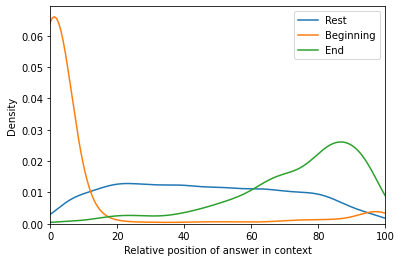

In [8]:
sns.kdeplot(rest.relative.to_numpy(), label='Rest')
sns.kdeplot(begining.relative.to_numpy(), label='Beginning')
sns.kdeplot(end.relative.to_numpy(), label='End')
plt.legend()
plt.xlim([0, 100])
# set x-axis label
plt.xlabel('Relative position of answer in context')
plt.savefig('Figures_For_Report/relative_position.png')
plt.show()

In [11]:
def Q_process(text):
    text = text.replace('"','')
    if text in to_keep:
        return text + " (B)"
    elif text in to_keep2:
        return text + " (E)"
    else:
        return text + " (R)"

,start_idx,answer_len,contex_len,question_idx,relative,question_name,question_name_long
0,44,21,54290,0,0.081046,"""Document Name""",Highlight the parts (if any) of this contract ...
1,244,11,54290,1,0.449438,"""Parties""",Highlight the parts (if any) of this contract ...
2,49574,32,54290,1,91.313317,"""Parties""",Highlight the parts (if any) of this contract ...
3,212,29,54290,1,0.390495,"""Parties""",Highlight the parts (if any) of this contract ...
4,197,7,54290,1,0.362866,"""Parties""",Highlight the parts (if any) of this contract ...
...,...,...,...,...,...,...,...
11175,12067,128,27166,32,44.419495,"""Post-Termination Services""",Highlight the parts (if any) of this contract ...
11176,12196,192,27166,33,44.894353,"""Audit Rights""",Highlight the parts (if any) of this contract ...
11177,20750,321,27166,38,76.382243,"""Insurance""",Highlight the parts (if any) of this contract ...
11178,21123,105,27166,38,77.755282,"""Insurance""",Highlight the parts (if any) of this contract ...


In [15]:
df['q_name_cat'] = df.apply(lambda x: Q_process(x['question_name']), axis=1)

In [18]:
df[['q_name_cat','question_name_long']].drop_duplicates().to_csv('qcategories.csv', index=False)